# Transaction time series processor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

raw_df = pd.read_csv("../DATA-MINING/OTHER-DATA/TRANS/trans_big.csv", encoding="cp1251")
raw_df = raw_df.drop(columns=['card', 'mcc', 'value'])
group_list = ['food', 'fun', 'travel', 'money', 'outfit', 'nonfood', 'telecom',
              'health', 'misc', 'kids', 'dwelling', 'remote', 'beauty', 'charity']
raw_df = raw_df[raw_df['group'].isin(group_list)]

In [2]:
raw_df.head()

,client,date,amt,group
0,390989,2018-01-01,878.0,food
1,1309946,2018-01-01,249.0,food
2,1386278,2018-01-01,50.0,food
3,475694,2018-01-01,2564.0,fun
4,710293,2018-01-01,464.9,food


In [3]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'
#plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), len(group_list)))
colors = [col.hex for col in color_objs]
print("Num of colors:", len(colors))
print("Unique groups:", raw_df['group'].unique())

unique_clients = len(raw_df['client'].unique())
unique_groups = len(raw_df['group'].unique())

print(f"Unique clients: {unique_clients}")
print(f"Unique groups: {unique_groups}")
print(f"Number of transactions: {len(raw_df)}")

Num of colors: 14
Unique groups: ['food' 'fun' 'travel' 'money' 'outfit' 'nonfood' 'telecom' 'health'
 'misc' 'kids' 'dwelling' 'remote' 'beauty' 'charity']
Unique clients: 10000
Unique groups: 14
Number of transactions: 19026862


## Prepare data for grouping

In [4]:
from datetime import date, datetime

datify = lambda x: datetime.strptime(x, '%Y-%m-%d')
textify = lambda x: x.strftime('%Y-%m-%d')

start_d, end_d = datify(min(raw_df['date'])), datify(max(raw_df['date']))
delta_d = end_d - start_d
num_days = delta_d.days

print(f"From {textify(start_d)} to {textify(end_d)}")
print(f"Number of days: {num_days}")

#raw_df['date'] = raw_df['date'].apply(datify)

From 2018-01-01 to 2022-08-15
Number of days: 1687


In [5]:
client_list = list(raw_df['client'].unique())
client_dict = {client_list[n]: n+1 for n in range(unique_clients)} # clients from 1 to 10000

raw_df['client'] = raw_df['client'].apply(lambda x: client_dict[x])
raw_df = raw_df.groupby(['group', 'date', 'client'])['amt'].sum().reset_index()

In [6]:
print(f"Number of transactions: {len(raw_df)}")
raw_df.head()

Number of transactions: 12831153


,group,date,client,amt
0,beauty,2018-01-01,207,1190.00
1,beauty,2018-01-01,258,3702.21
2,beauty,2018-01-01,492,2500.00
3,beauty,2018-01-01,663,408.50
4,beauty,2018-01-02,8,1290.00


## Build the time series

In [7]:
all_dates = pd.date_range(start=start_d,
                          end=end_d).to_list()
all_dates = [textify(item) for item in all_dates]

print("Groups: {", end=" ")

for cur_group in group_list:
    temp_raw = raw_df[raw_df['group'] == cur_group].drop(columns=['group'])
    temp_ts = temp_raw.pivot(index="date",
                             columns="client",
                             values="amt").reindex(columns=list(range(1, unique_clients+1)))
    temp_ts = temp_ts.reindex(all_dates)
    temp_ts = temp_ts.fillna(0.0)
    
    temp_ts.to_csv(f'./PROCESSED-DATA/TRANS/{cur_group}.csv')
    
    print(cur_group, end=" ")

print("} generated.")

Groups: { food fun travel money outfit nonfood telecom health misc kids dwelling remote beauty charity } generated.


## Prepare macro-level dataframe

In [8]:
def read_cli(path):
    temp_ts = pd.read_csv(path)
    temp_ts['date'] = temp_ts['date'].apply(datify)
    temp_ts = temp_ts.set_index('date')
    return temp_ts

In [9]:
all_df = pd.DataFrame(columns=group_list)

print("Groups: {", end=" ")

for cur_group in group_list:
    all_df[cur_group] = read_cli(f'./PROCESSED-DATA/TRANS/{cur_group}.csv').sum(axis=1)
    print(cur_group, end=" ")

print("} accumulated.")
all_df.to_csv(f'./PROCESSED-DATA/TRANS/MACRO-TRANS.csv')

Groups: { food fun travel money outfit nonfood telecom health misc kids dwelling remote beauty charity } accumulated.


## Look at the dataset

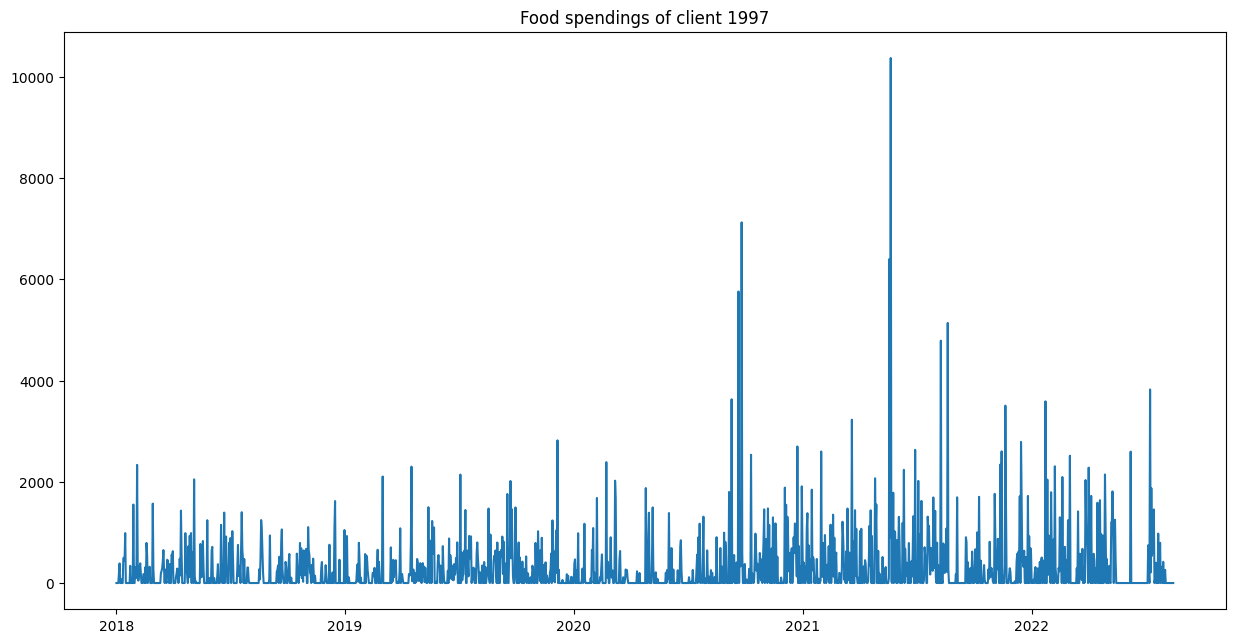

In [10]:
# Money for food of random client
food_df = read_cli('./PROCESSED-DATA/TRANS/food.csv')
cli = str(np.random.randint(0, unique_clients))

plt.plot(food_df[cli])
plt.title(f"Food spendings of client {cli}");

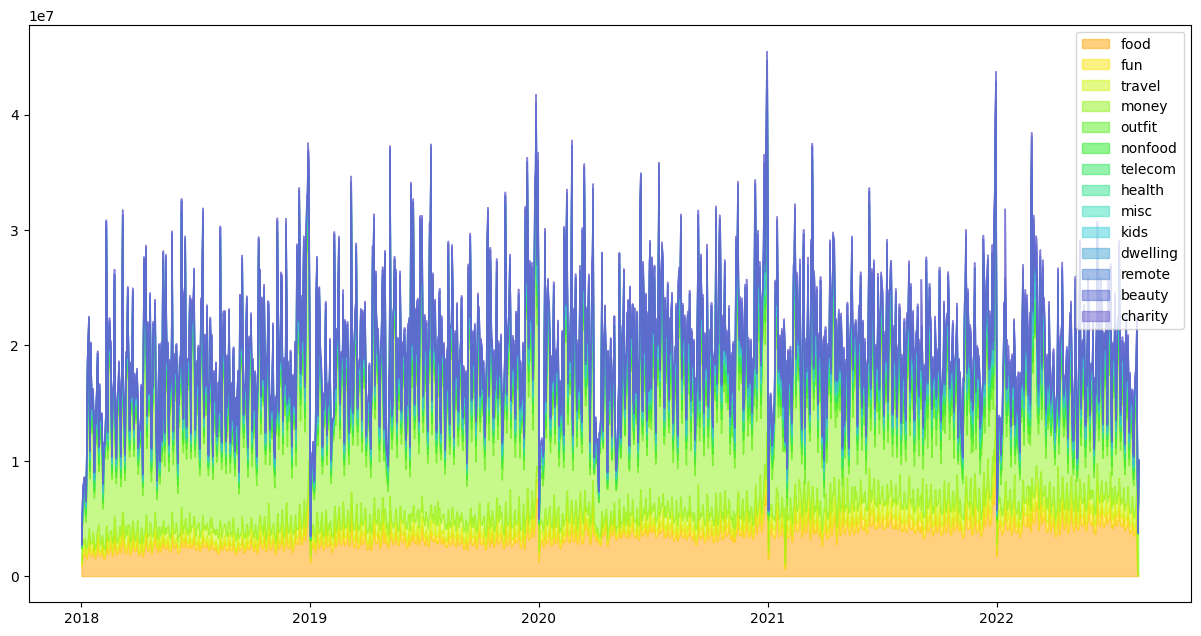

In [11]:
# Cumulative plot for different groups of all clients
all_df = read_cli('./PROCESSED-DATA/TRANS/MACRO-TRANS.csv')
n = len(all_df)
client_sum = all_df.T.to_numpy();

x = pd.date_range(start=start_d, end=end_d).to_list()
y = np.zeros(n)

stack = [client_sum[n][:] for n in range(unique_groups)]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp, y, color=c[i], alpha=0.5)

plt.legend(tuple(group_list));

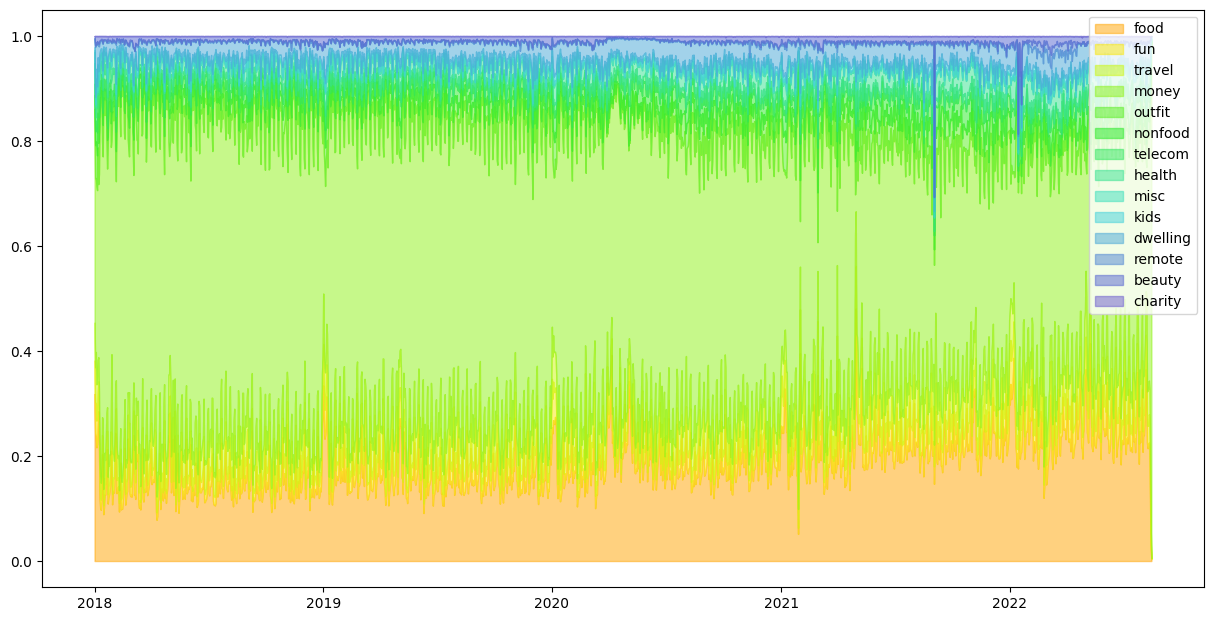

In [12]:
# Normalized cumulative plot for different groups of all clients
# Cumulative plot for different groups of all clients
all_df = read_cli('./PROCESSED-DATA/TRANS/MACRO-TRANS.csv')
n = len(all_df)
client_sum = all_df.T.to_numpy();
mega_sum = client_sum.sum(axis=0).reshape(n);

x = pd.date_range(start=start_d, end=end_d).to_list()
y = np.zeros(n)

stack = [client_sum[n][:] for n in range(unique_groups)]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp/mega_sum, y/mega_sum, color=c[i], alpha=0.5)

plt.legend(tuple(group_list));